In [1]:
%matplotlib notebook
from __future__ import division

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from matplotlib.pyplot import plot, ylabel, xlabel, yscale, xscale, legend, subplots, gca, gcf
from matplotlib.ticker import FormatStrFormatter
from theano import function
import numpy as np
import gzip
import cPickle
from scipy.optimize import minimize
from climin.util import optimizer
from itertools import repeat, cycle, islice, izip
import random
inf = float("inf")

gnumpy: failed to import cudamat. Using npmat instead. No GPU will be used.


In [3]:
from breze.learn.data import one_hot
from breze.learn.base import cast_array_to_local_type
from schlichtanders.myfunctools import compose, meanmap, summap, compose_fmap, Average
from schlichtanders import myfunctools
from schlichtanders.mygenerators import eatN, chunk, chunk_list, every, takeN
from schlichtanders.myplot import add_val, add_point

In [4]:
from theano_models import (Merge, Flatten, Reparameterize, reduce_all_identities,
                           inputting_references, outputting_references)
from theano_models.tools import (as_tensor_variable, total_size, clone, clone_all,PooledRandomStreams,
                                 get_profile, squareplus, squareplus_inv, softplus, softplus_inv)
from theano_models.visualization import d3viz
from IPython.display import IFrame
import theano_models.deterministic_models as dm
import theano_models.probabilistic_models as pm
import theano_models.extra_models as em
import theano_models.postmaps as post
from theano_models.composing import normalizing_flow, variational_bayes

In [5]:
import theano
import theano.tensor as T
from theano.printing import debugprint
from theano.tensor.shared_randomstreams import RandomStreams

In [6]:
from sqlalchemy import Column, Integer, Unicode, UnicodeText, String, PickleType, Float
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy.ext.declarative import declarative_base

In [7]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [8]:
inputting_references.update(['to_be_randomized'])
inputting_references, outputting_references

({'flat',
  'inputs',
  'n_data',
  'noise',
  'parameters',
  'parameters_positive',
  'parameters_psumto1',
  'to_be_randomized'},
 {'kl_prior', 'logP', 'loglikelihood', 'norm_det', 'outputs'})

In [9]:
from schlichtanders.myobjects import NestedNamespace

In [10]:
pm.RNG = NestedNamespace(PooledRandomStreams(pool_size=int(5e8)), RandomStreams())

# Data

In [11]:
datafile = '../data/mnist.pkl.gz'
# Load data.        a                                                                                           

with gzip.open(datafile,'rb') as f:                                                                        
    train_set, val_set, test_set = cPickle.load(f)                                                       

X, Z = train_set                                                                                               
VX, VZ = val_set
TX, TZ = test_set

Z = one_hot(Z, 10)
VZ = one_hot(VZ, 10)
TZ = one_hot(TZ, 10)

# from UncertainWeightsPaper rescaled the data,
# however it already seems to be normalized
# X /= 126  
# VX /= 126
# TX /= 126
# X *= 2
# VX *= 2
# TX *= 2

image_dims = 28, 28

X, Z, VX, VZ, TX, TZ = [cast_array_to_local_type(i) for i in (X, Z, VX,VZ, TX, TZ)]
map(np.shape, [X, Z, VX, VZ, TX, TZ])

[(50000, 784),
 (50000, 10),
 (10000, 784),
 (10000, 10),
 (10000, 784),
 (10000, 10)]

# Hyperparameters

In [12]:
engine = create_engine('sqlite:///hyperparameters.db')
Base = declarative_base(bind=engine)

class RandomHyper(Base):
    __tablename__ = 'hyper'
    id = Column(Integer, primary_key=True)
    
    # hyper parameters:
    n_epochs = Column(Integer)
    batch_size = Column(Integer)
    mapreduce = Column(String)
    average_n = Column(Integer)
    units_per_layer = Column(Integer)
    pi = Column(Float)
    minus_log_s1 = Column(Integer)
    minus_log_s2 = Column(Integer)
    
    n_normflows = Column(Integer)
    
    opt_identifier = Column(String)
    opt_momentum = Column(Float)
    opt_offset = Column(Float)
    opt_decay = Column(Float)
    opt_step_rate = Column(Float)
    
    # results:
    best_val_loss = Column(Float)
    best_parameters = Column(PickleType, nullable=True)
    train_loss = Column(PickleType)
    val_loss = Column(PickleType)

    def __init__(self):
        # hyper parameters:
        self.n_epochs = 20
        self.batch_size = 128
        self.mapreduce = random.choice(["summap", "meanmap"])
        self.average_n = 1
        self.units_per_layer = np.random.choice([400, 800, 1200], p=[0.5, 0.3, 0.2])
        self.pi = random.choice([1/4, 1/2, 3/4])
        self.minus_log_s1 = random.choice([0,1,2])
        self.minus_log_s2 = random.choice([6,7,8])
        
        self.n_normflows = random.choice([1,2,3,4,8,32])
        
        self.opt_identifier = random.choice(["adadelta", "adam", "rmsprop"])
        if self.opt_identifier == "adadelta":
            self.opt_momentum = random.choice([np.random.uniform(0, 0.01), np.random.uniform(0.9, 1)])
            self.opt_offset = random.choice([5e-5, 1e-8])
        elif self.opt_identifier == "adam":
            self.opt_momentum = random.choice([np.random.uniform(0, 0.01), np.random.uniform(0.8, 0.93)])
            self.opt_offset = 10 ** -np.random.uniform(3, 4)
        elif self.opt_identifier == "rmsprop":
            self.opt_momentum = random.choice([np.random.uniform(0.002, 0.008), np.random.uniform(0.9, 1)]),
            self.opt_offset = np.random.uniform(0, 0.000045)
        self.opt_decay = np.random.uniform(0.78, 1)
        self.opt_step_rate = random.choice([1e-3, 1e-4, 1e-5])
        
        self.init_results()
    
    def init_results(self):
        # extra for being able to reset results for loaded hyperparameters
        self.best_parameters = None
        self.best_val_loss = inf
        self.train_loss = []
        self.val_loss = []

Base.metadata.create_all()
Session = sessionmaker(bind=engine)
sql_session = Session()
hyper = RandomHyper()
hyper.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7ff256ec9a10>,
 'average_n': 1,
 'batch_size': 128,
 'best_parameters': None,
 'best_val_loss': inf,
 'mapreduce': 'meanmap',
 'minus_log_s1': 2,
 'minus_log_s2': 8,
 'n_epochs': 20,
 'n_normflows': 8,
 'opt_decay': 0.9017948335304217,
 'opt_identifier': 'adadelta',
 'opt_momentum': 0.9265495767077205,
 'opt_offset': 1e-08,
 'opt_step_rate': 0.001,
 'pi': 0.75,
 'train_loss': [],
 'units_per_layer': 400,
 'val_loss': []}

# Model

## data modelling

In [13]:
# this is extremely useful to tell everything the default sizes
input = as_tensor_variable(X[0], name="X")

In [14]:
predictor = dm.Mlp(
    input=input,
    output_size=Z.shape[1],
    output_transfer="softmax",
    hidden_sizes=[hyper.units_per_layer]*2,
    hidden_transfers=["rectifier"]*2
)
predictor

Mlp { 'inputs': [X],
  'outputs': AffineNonlinear3.outputs,
  'parameters': [weights, bias, weights2, bias2, weights3, bias3]}

In [15]:
target_distribution = pm.Categorical(predictor)
target_distribution

Categorical { 'inputs': [],
  'logP': <FunctionWrapper at 0x7ff25611bde0 for function at 0x7ff255f6b2a8>,
  'outputs': Categorical.outputs,
  'parameters_psumto1': [AffineNonlinear3.outputs]}

In [16]:
targets = Merge(target_distribution, predictor,
                Flatten(predictor['parameters'], flat_key="to_be_randomized")) #givens={predictor['inputs'][0]: X[0]}
targets

Merge { 'inputs': [X],
  'logP': <FunctionWrapper at 0x7ff25611bde0 for function at 0x7ff255f6b2a8>,
  'outputs': Categorical.outputs,
  'parameters': [],
  'parameters_psumto1': [],
  'to_be_randomized': "weights:bias:weights2:bias2:weights3:bias3"}

## parameter modelling

In [17]:
params_base = pm.DiagGauss(output_size=total_size(targets['to_be_randomized']))  
# if you want to use size directly, CAUTION, you need to copy before!
# params_base.map('parameters_positive', reparameterize_map(squareplus, squareplus_inv), 'parameters')
params_base

DiagGauss { 'inputs': [],
  'logP': <FunctionWrapper at 0x7ff23f457c20 for function at 0x7ff23b3fe8c0>,
  'noise': [DiagGaussianNoise.noise.0],
  'outputs': DiagGaussianNoise.outputs,
  'parameters': [mean],
  'parameters_positive': [var]}

In [18]:
normflows = [dm.PlanarTransform() for _ in range(hyper.n_normflows)]
normflows

[PlanarTransform { 'inputs': [z],
   'norm_det': PlanarTransform.norm_det,
   'outputs': PlanarTransform.outputs,
   'parameters': [b, w, _u]}, PlanarTransform2 { 'inputs': [z2],
   'norm_det': PlanarTransform2.norm_det,
   'outputs': PlanarTransform2.outputs,
   'parameters': [b2, w2, _u2]}, PlanarTransform3 { 'inputs': [z3],
   'norm_det': PlanarTransform3.norm_det,
   'outputs': PlanarTransform3.outputs,
   'parameters': [b3, w3, _u3]}, PlanarTransform4 { 'inputs': [z4],
   'norm_det': PlanarTransform4.norm_det,
   'outputs': PlanarTransform4.outputs,
   'parameters': [b4, w4, _u4]}, PlanarTransform5 { 'inputs': [z5],
   'norm_det': PlanarTransform5.norm_det,
   'outputs': PlanarTransform5.outputs,
   'parameters': [b5, w5, _u5]}, PlanarTransform6 { 'inputs': [z6],
   'norm_det': PlanarTransform6.norm_det,
   'outputs': PlanarTransform6.outputs,
   'parameters': [b6, w6, _u6]}, PlanarTransform7 { 'inputs': [z7],
   'norm_det': PlanarTransform7.norm_det,
   'outputs': PlanarTransform

In [19]:
params = params_base
for transform in normflows:
    params = normalizing_flow(transform, params)  # returns transform, however with adapted logP    

params

normalized_flow8 { 'inputs': [],
  'logP': <FunctionWrapper at 0x7ff23b3caf30 for function at 0x7ff21b572668>,
  'noise': [DiagGaussianNoise.noise.0],
  'norm_det': PlanarTransform8.norm_det,
  'outputs': PlanarTransform8.outputs,
  'parameters': [ b8,
                  w8,
                  _u8,
                  b7,
                  w7,
                  _u7,
                  b6,
                  w6,
                  _u6,
                  b5,
                  w5,
                  _u5,
                  b4,
                  w4,
                  _u4,
                  b3,
                  w3,
                  _u3,
                  b2,
                  w2,
                  _u2,
                  b,
                  w,
                  _u,
                  mean],
  'parameters_positive': [var]}

## bayes

In [20]:
g1 = pm.Gauss(total_size(targets['to_be_randomized']), init_var=np.exp(-2* hyper.minus_log_s1))
g2 = pm.Gauss(total_size(targets['to_be_randomized']), init_var=np.exp(-2* hyper.minus_log_s2))
prior = pm.Mixture(g1, g2, mixture_probs=[hyper.pi, 1-hyper.pi])
# label hyper parameters accordingly
prior = Merge(prior,
              parameters=None, # mean is not adapted at all, but left centred at zero
              parameters_positive='hyperparameters_positive',
              parameters_psumto1='hyperparameters_psumto1')
prior

Merge3 { 'hyperparameters_positive': [var2, var3],
  'hyperparameters_psumto1': [mixture_probs],
  'inputs': [],
  'logP': <FunctionWrapper at 0x7ff2563bc750 for function at 0x7ff21b591c80>,
  'mixture_probs': [0.75, 0.25],
  'noise': [GaussianNoise.noise.0, GaussianNoise2.noise.0],
  'outputs': Mixture.outputs,
  'parameters': []}

In [21]:
model = variational_bayes(targets, 'to_be_randomized', params, priors=prior)
model

variational_lower_bound { 'hyperparameters_positive': [var2, var3],
  'hyperparameters_psumto1': [mixture_probs],
  'inputs': [X],
  'kl_prior': kl_prior,
  'logP': <FunctionWrapper at 0x7ff21b5030c0 for function at 0x7ff21b591410>,
  'loglikelihood': <FunctionWrapper at 0x7ff25611bde0 for function at 0x7ff255f6b2a8>,
  'mixture_probs': [0.75, 0.25],
  'n_data': n_data,
  'noise': [ DiagGaussianNoise.noise.0,
             GaussianNoise.noise.0,
             GaussianNoise2.noise.0],
  'norm_det': PlanarTransform8.norm_det,
  'outputs': Categorical.outputs,
  'parameters': [ b8,
                  w8,
                  _u8,
                  b7,
                  w7,
                  _u7,
                  b6,
                  w6,
                  _u6,
                  b5,
                  w5,
                  _u5,
                  b4,
                  w4,
                  _u4,
                  b3,
                  w3,
                  _u3,
                  b2,
              

In [22]:
# model = Merge(model, Reparameterize(model['parameters_positive'], squareplus, squareplus_inv))
# UncertainWeights uses softplus parameterization
model = Merge(model, Reparameterize(model['parameters_positive'], softplus, softplus_inv))
model

Merge4 { 'hyperparameters_positive': [var2, var3],
  'hyperparameters_psumto1': [mixture_probs],
  'inputs': [X],
  'kl_prior': kl_prior,
  'logP': <FunctionWrapper at 0x7ff21b5030c0 for function at 0x7ff21b591410>,
  'loglikelihood': <FunctionWrapper at 0x7ff25611bde0 for function at 0x7ff255f6b2a8>,
  'mixture_probs': [0.75, 0.25],
  'n_data': n_data,
  'noise': [ DiagGaussianNoise.noise.0,
             GaussianNoise.noise.0,
             GaussianNoise2.noise.0],
  'norm_det': PlanarTransform8.norm_det,
  'outputs': Categorical.outputs,
  'parameters': [ b8,
                  w8,
                  _u8,
                  b7,
                  w7,
                  _u7,
                  b6,
                  w6,
                  _u6,
                  b5,
                  w5,
                  _u5,
                  b4,
                  w4,
                  _u4,
                  b3,
                  w3,
                  _u3,
                  b2,
                  w2,
         

In [23]:
model = Merge(model, Flatten(model['parameters']))
#               em.NoisePool(model['noise']) #, givens={predictor['inputs'][0]: X[0]}
model

Merge5 { 'flat': "b8:w8:_u8:b7:w7:_u7:b6:w6:_u6:b5:w5:_u5:b4:w4:_u4:b3:w3:_u3:b2:w2:_u2:b:w:_u:mean:var_softplus",
  'hyperparameters_positive': [var2, var3],
  'hyperparameters_psumto1': [mixture_probs],
  'inputs': [X],
  'kl_prior': kl_prior,
  'logP': <FunctionWrapper at 0x7ff21b5030c0 for function at 0x7ff21b591410>,
  'loglikelihood': <FunctionWrapper at 0x7ff25611bde0 for function at 0x7ff255f6b2a8>,
  'mixture_probs': [0.75, 0.25],
  'n_data': n_data,
  'noise': [ DiagGaussianNoise.noise.0,
             GaussianNoise.noise.0,
             GaussianNoise2.noise.0],
  'norm_det': PlanarTransform8.norm_det,
  'outputs': Categorical.outputs,
  'parameters': [],
  'parameters_positive': [],
  'parameters_psumto1': []}

# Optimizer

In [24]:
# dm.InvertibleModel.INVERTIBLE_MODELS
reduce_all_identities()
# dm.InvertibleModel.INVERTIBLE_MODELS

Climin wants an iterator of (args, kwarsg) as keyword argument "args" (to be passed to the loss function). Concretley, we use an infinite iterator over minibatches.

In [25]:
n_batches = X.shape[0] // hyper.batch_size  # after this many steps we went through the whole data set once

climin_args = izip(izip(chunk(hyper.batch_size, cycle(Z)), chunk(hyper.batch_size, cycle(X))), repeat({}))

def weights_regularizer_1epoch():
    for i in range(1, n_batches+1):
        yield 2**(n_batches - i) / (2**n_batches - 1)
        
assert len(list(weights_regularizer_1epoch())) == n_batches

In [26]:
mapreduce = getattr(myfunctools, hyper.mapreduce)
if hyper.average_n > 1:
    mapreduce = compose_fmap(Average(hyper.average_n), mapreduce)

postmap = compose(post.flat_numericalize_postmap, post.variational_postmap) 
postmap_kwargs = {
    'mapreduce': mapreduce,  # TODO add more functionality for composed fmaps, with args
    'annealing_combiner': post.AnnealingCombiner(
        weights_regularizer=cycle(weights_regularizer_1epoch())
    ),
    'adapt_init_params': lambda ps: ps + np.random.normal(size=ps.size, scale=0.01),
#     'profile': True,
    'mode': 'FAST_RUN'
}
optimizer_kwargs = postmap(model, **postmap_kwargs)
climin_kwargs = post.climin_postmap(optimizer_kwargs)
climin_kwargs

{'f': <function theano_models.postmaps.annealed>,
 'fprime': <function theano_models.postmaps.annealed>,
 'wrt': array([ 0.00584543,  1.02605545,  0.99497776, ...,  0.57297313,
         0.53271813,  0.53152113])}

In [27]:
opt = optimizer(
    identifier=hyper.opt_identifier,
    step_rate=hyper.opt_step_rate,
    momentum=hyper.opt_momentum,
    decay=hyper.opt_decay,
    offset=hyper.opt_offset,
    
    args=climin_args,
    **climin_kwargs
)

/home/stephan/GitProjects/breze/src/climin/climin/util.py:151: UserWarning: Argument named f is not expected by <class 'climin.adadelta.Adadelta'>
  % (i, klass))


# Visualized Fit

<IPython.core.display.Javascript object>


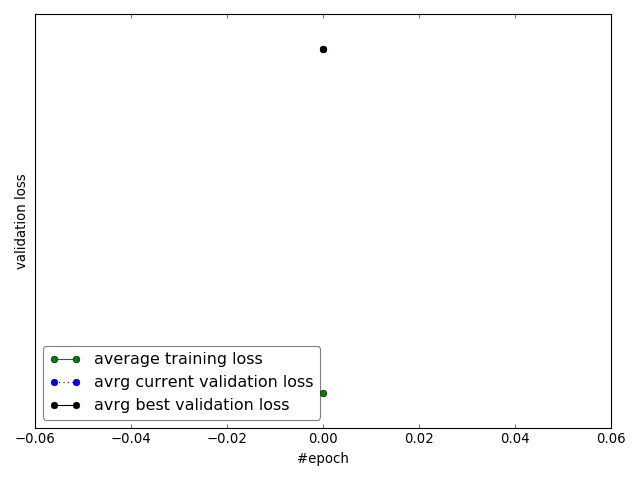

In [28]:
# plot: 
line_train, = plot([], [], 'go-', label="average training loss")
line_curr_val, = plot([],[], 'bo:', label="avrg current validation loss")
line_best_val, = plot([], [], 'ko-', label="avrg best validation loss")
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
yscale('log')
gca().yaxis.set_minor_formatter(FormatStrFormatter("%.2g"))
ylabel("validation loss")
xlabel("#epoch")
legend(loc='lower left', fancybox=True, framealpha=0.5)

# start values:
val_loss = optimizer_kwargs['num_loss'](optimizer_kwargs['num_parameters'], VZ, VX, no_annealing=True)
training_loss = optimizer_kwargs['num_loss'](optimizer_kwargs['num_parameters'], Z[:10], X[:10], no_annealing=True)
start_epoch = opt.n_iter//n_batches

add_point(line_best_val, start_epoch, val_loss)
add_point(line_curr_val, start_epoch, val_loss)
add_point(line_train, start_epoch, training_loss)

In [ ]:
for info in takeN(hyper.n_epochs, every(n_batches, opt)):
    current_epoch = info['n_iter']//n_batches
    # collect and visualize validation loss for choosing the best model
    val_loss = optimizer_kwargs['num_loss'](opt.wrt, VZ, VX, no_annealing=True)
    if val_loss < hyper.best_val_loss:
        hyper.best_parameters = opt.wrt
        hyper.best_val_loss = val_loss
        add_point(line_best_val, current_epoch, val_loss)
    hyper.val_loss.append(val_loss)
    add_point(line_curr_val, current_epoch, val_loss)
    
    # visualize training loss for comparison:
    training_loss = optimizer_kwargs['num_loss'](opt.wrt, Z[:10], X[:10], no_annealing=True)
    hyper.train_loss.append(training_loss)
    add_point(line_train, current_epoch, training_loss)
    
#     print info['n_iter'], training_loss, val_loss, best_val_loss

In [ ]:
sql_session.add(hyper)
sql_session.commit()

# Performance

TODO: average over predictions

In [ ]:
print best_val_loss
model['flat'] = best_wrt

predict = mlp.function()
predict(X[0]), Z[0]

In [ ]:
PX = np.apply_along_axis(predict, 1, X)
PVX = np.apply_along_axis(predict, 1, VX)
PTX = np.apply_along_axis(predict, 1, TX)

In [ ]:
print 'incorrect samples train/val/test:  %i/%i/%i' % (
    (PX[:, :10].argmax(1) != Z.argmax(1)).sum(),
    (PVX[:, :10].argmax(1) != VZ.argmax(1)).sum(),
    (PTX[:, :10].argmax(1) != TZ.argmax(1)).sum())

print 'error rate train/val/test:  %g/%g/%g' % (
    (PX[:, :10].argmax(1) != Z.argmax(1)).mean(),
    (PVX[:, :10].argmax(1) != VZ.argmax(1)).mean(),
    (PTX[:, :10].argmax(1) != TZ.argmax(1)).mean())